# Model Iterations

In this notebook I continue to iterate on my FMS and explore class imbalance and regularisation. 

In [92]:
# imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# variable for file path from this directory
to_data = '../../../data/'

In [20]:
# import latest 
df = pd.read_csv(to_data + 'initial_clean_lc', index_col = 0)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [13]:
df.voice_mail_plan.replace((True, False), (1, 0), inplace = True)
df.international_plan.replace((True, False), (1, 0), inplace = True)
df.churn.replace((True, False), (1, 0), inplace = True)

In [21]:
y = df.churn
y.head()

0    False
1    False
2    False
3    False
4    False
Name: churn, dtype: bool

In [22]:
X = df.drop("churn", axis=1)
X.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [23]:
X = pd.get_dummies(X, drop_first = True)
X.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,415,False,True,25,265.1,110,45.07,197.4,99,...,0,0,0,0,0,0,0,0,0,0
1,107,415,False,True,26,161.6,123,27.47,195.5,103,...,0,0,0,0,0,0,0,0,0,0
2,137,415,False,False,0,243.4,114,41.38,121.2,110,...,0,0,0,0,0,0,0,0,0,0
3,84,408,True,False,0,299.4,71,50.90,61.9,88,...,0,0,0,0,0,0,0,0,0,0
4,75,415,True,False,0,166.7,113,28.34,148.3,122,...,0,0,0,0,0,0,0,0,0,0


# First Shitty Model - base tree model:

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.25, 
                                                    random_state = 15)

X_t, x_val, y_t, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 15)

In [105]:
# Instantiate and fit a DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=5, random_state = 42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

#### Training Scores:

In [58]:
print(recall_score(y_train, dtc.predict(X_train)))
print(accuracy_score(y_train, dtc.predict(X_train)))

0.7388888888888889
0.9559823929571829


#### Testing Scores:

In [59]:
print(recall_score(y_test, dtc.predict(X_test)))
print(accuracy_score(y_test, dtc.predict(X_test)))

0.6260162601626016
0.9328537170263789


#### Check for class imbalance:

In [60]:
y_train.value_counts()

False    2139
True      360
Name: churn, dtype: int64

There is definitely class imbalance issues here.

#### Check Feature Importance:

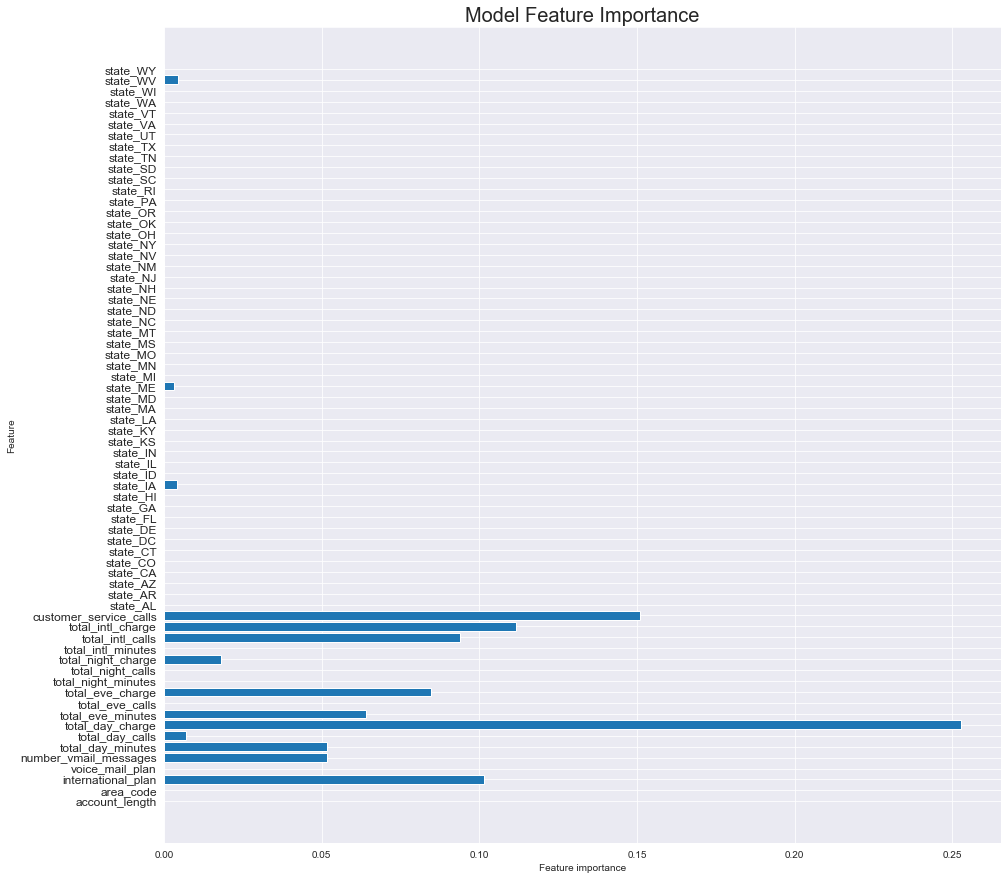

In [61]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_) 
    plt.yticks(np.arange(n_features), X_train.columns.values, fontsize = 12) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Model Feature Importance', fontsize = 20)

plot_feature_importances(dtc)

## Model 2:  Random Forest Model

In [62]:
rft = RandomForestClassifier(n_estimators=1000, max_depth= 10, max_features = 5, class_weight = 'balanced', random_state = 42)
rft.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [63]:
recall_score(y_test, rft.predict(X_test))

0.6666666666666666

In [64]:
recall_score(y_train, rft.predict(X_train))

0.8833333333333333

## Model 3:  Balance Classes - base tree model:

In [65]:
dtc2 = DecisionTreeClassifier(max_depth=5, class_weight = 'balanced', random_state = 42)
dtc2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

#### Training Scores:

In [66]:
print(recall_score(y_train, dtc2.predict(X_train)))
print(accuracy_score(y_train, dtc2.predict(X_train)))

0.8555555555555555
0.9351740696278511


#### Testing Scores:

In [67]:
print(recall_score(y_test, dtc2.predict(X_test)))
print(accuracy_score(y_test, dtc2.predict(X_test)))

0.7886178861788617
0.9232613908872902


Got better results here but this time I need to scale the data:

## Model 4:  Scale Data with balanced classes - base tree model:

In [68]:
dtc3 = DecisionTreeClassifier(max_depth=5, class_weight = 'balanced', random_state = 42)
ss = StandardScaler()
ss.fit(X_train)

X_train_sc = ss.transform(X_train)

dtc3.fit(X_train_sc, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

#### Training Scores:

In [69]:
print(recall_score(y_train, dtc3.predict(X_train_sc)))
print(accuracy_score(y_train, dtc3.predict(X_train_sc)))

0.8555555555555555
0.9351740696278511


In [70]:
cross_val_score(dtc3, X_train_sc, y_train, cv=5, scoring='recall')

array([0.76388889, 0.80555556, 0.77777778, 0.86111111, 0.72222222])

## Model 5:  Grid Search

In [98]:
dtc4 = DecisionTreeClassifier(random_state = 42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1.0, 5, 10, 20],
    'class_weight': ['balanced', None]
}

gs_tree = GridSearchCV(dtc4, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 5}

## Model 6:  Gride search result params:

In [77]:
dtc5 = DecisionTreeClassifier(max_depth = 5, min_samples_split = 5, class_weight = 'balanced', random_state = 42)
dtc5.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [81]:
print('recall train ', recall_score(y_train, dtc5.predict(X_train)))
print('accuracy train ', accuracy_score(y_train, dtc5.predict(X_train)))
print('recall test ', recall_score(y_test, dtc5.predict(X_test)))
print('accuracy test ', accuracy_score(y_test, dtc5.predict(X_test)))

recall train  0.8555555555555555
accuracy train  0.9351740696278511
recall test  0.7886178861788617
accuracy test  0.9232613908872902


In [82]:
confusion_matrix(y_train, dtc5.predict(X_train))

array([[2029,  110],
       [  52,  308]])

In [83]:
confusion_matrix(y_test, dtc5.predict(X_test))

array([[673,  38],
       [ 26,  97]])

Still quite imbalanced...

In [89]:
def run_model(classifier, X, y):
    model = classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)
    
    # model params
    print(model.fit(X_train, y_train))
    
    # recall scores:
    print(f"Training recall score: {recall_score(y_train, model.predict(X_train))}")
    print(f"Test recall score: {recall_score(y_test, model.predict(X_test))}")
    
    #Cross val scores for recall:
    print(f"Cross val Score train:  {cross_val_score(model, X_train, y_train, cv=5, scoring='recall')}")
    print(f"Cross val Score test:  {cross_val_score(model, X_test, y_test, cv=5, scoring='recall')}")
    
    # Confusion matrix:
    print(f"Train: \n{confusion_matrix(y_train, model.predict(X_train))}")
    print(f"Test: \n{confusion_matrix(y_test, model.predict(X_test))}")

In [85]:
run_model(dtc5, X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Training recall score: 0.8555555555555555
Test recall score: 0.7886178861788617
Cross val Score train:  [0.76388889 0.80555556 0.77777778 0.86111111 0.72222222]
Cross val Score test:  [0.76 0.64 0.8  0.75 0.75]
Train: [[2029  110]
 [  52  308]]
Test: [[673  38]
 [ 26  97]]


# Model 7:  Random Forest with Grid Search

In [99]:
rft2 = RandomForestClassifier(random_state = 42)
param_grid = {
    'n_estimators': [10, 100],
    'max_depth': [5, 10, 15, 20],
    'max_features': [5, 10, 15, 20],
    'class_weight': ["balanced", "balanced_subsample", None]
}

gs_tree = GridSearchCV(rft2, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_


{'class_weight': None,
 'max_depth': 20,
 'max_features': 20,
 'n_estimators': 100}

In [100]:
gs_tree.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [102]:
gs_tree.__dict__

{'scoring': None,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators='warn',
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 'n_jobs': None,
 'iid': 'warn',
 'refit': True,
 'cv': 3,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': 'raise-deprecating',
 'return_train_score': False,
 'param_grid': {'n_estimators': [10, 100],
  'max_depth': [5, 10, 15, 20],
  'max_features': [5, 10, 15, 20],
  'class_weight': ['balanced', 'balanced_subsample', None]},
 'multimetric_': False,
 'best_index_': 95,
 'best_score_': 0.9491796718687475,
 'best_params_': {'class_weight': None,
  'max_d

In [101]:
run_model(gs_tree.best_estimator_, X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training recall score: 1.0
Test recall score: 0.7317073170731707
Cross val Score train:  [0.70833333 0.77777778 0.70833333 0.72222222 0.66666667]
Cross val Score test:  [0.72       0.56       0.72       0.66666667 0.75      ]
Train: 
[[2139    0]
 [   0  360]]
Test: 
[[703   8]
 [ 33  90]]


In [106]:
gs_tree.best_estimator_.feature_importances_

array([0.02149729, 0.00625903, 0.08072713, 0.02448344, 0.03247619,
       0.1367276 , 0.02519253, 0.11762398, 0.06428559, 0.02100851,
       0.06593673, 0.02681525, 0.02288454, 0.02785934, 0.03849417,
       0.06300866, 0.04134358, 0.11384357, 0.00069526, 0.00121489,
       0.00128142, 0.00252972, 0.00143273, 0.00185433, 0.00242256,
       0.00047713, 0.00092463, 0.00097216, 0.00031942, 0.00083204,
       0.00134456, 0.00096276, 0.00036348, 0.00129402, 0.0005881 ,
       0.00079131, 0.00083008, 0.00243248, 0.00219645, 0.00112318,
       0.00041326, 0.00089381, 0.00399156, 0.00230346, 0.00153642,
       0.00154803, 0.00015773, 0.00053188, 0.00324652, 0.00097674,
       0.00108533, 0.00283443, 0.00268291, 0.00078801, 0.00203006,
       0.00154961, 0.00096903, 0.00227539, 0.00104627, 0.00022534,
       0.00288449, 0.00074216, 0.00147989, 0.00106933, 0.00149529,
       0.00194344, 0.00043868, 0.0015111 ])

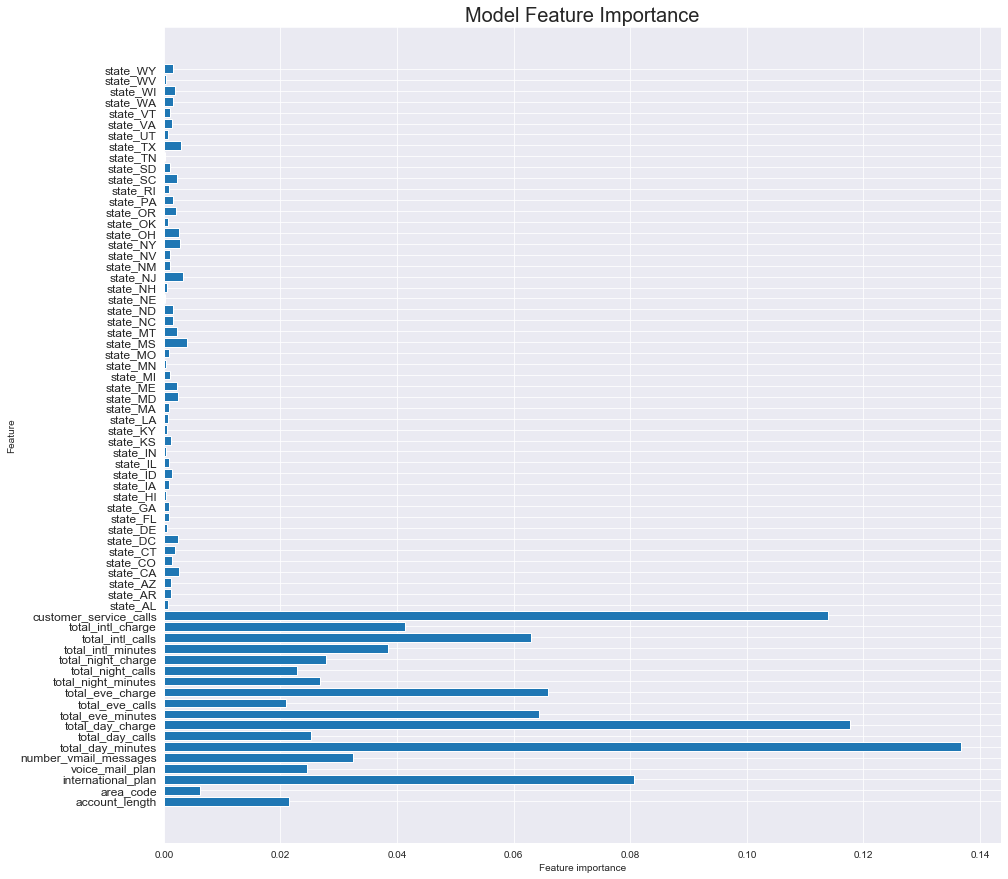

In [107]:
plot_feature_importances(gs_tree.best_estimator_)

In [87]:
rft2 = RandomForestClassifier(n_estimators=1000, max_depth=15, max_features = 10, class_weight = 'balanced_subsample', random_state = 42)

In [103]:
run_model(rft2, X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training recall score: 0.9471698113207547
Test recall score: 0.6
Cross val Score train:  [0.47169811 0.52830189 0.47169811 0.52830189 0.33962264]
Cross val Score test:  [0.10526316 0.31578947 0.36842105 0.36842105 0.42105263]
Train: 
[[1609    0]
 [  14  251]]
Test: 
[[524   6]
 [ 38  57]]


It looks like this model is overfitting.  This may be due to the depth being 15.  It also still looks quite imbalanced...

Let's try reducing depth and addressing the class imbalance on the next random forest.. 

First though, I want to try out gradient boosting models:

## Model 8:  Vanilla Gradient Boosting

In [91]:
gbc = GradientBoostingClassifier(random_state = 15)
run_model(gbc, X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=15, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Training recall score: 0.8194444444444444
Test recall score: 0.7235772357723578
Cross val Score train:  [0.69444444 0.77777778 0.69444444 0.76388889 0.63888889]
Cross val Score test:  [0.76       0.6        0.68       0.54166667 0.66666667]
Train: 
[[2137    2]
 [  65  295]]
Test: 
[[704   7]
 [ 34  89]]


Getting very similar confusion matrices as the last random forest model.  

Recall scores are closer to each other though so perhaps this is overfitting less.  More consistency in the cross vals scores as well between test and train. 

Let's look at the ROC-AUC of random forest and gradient boost models:

AUC: 0.9079048174447989


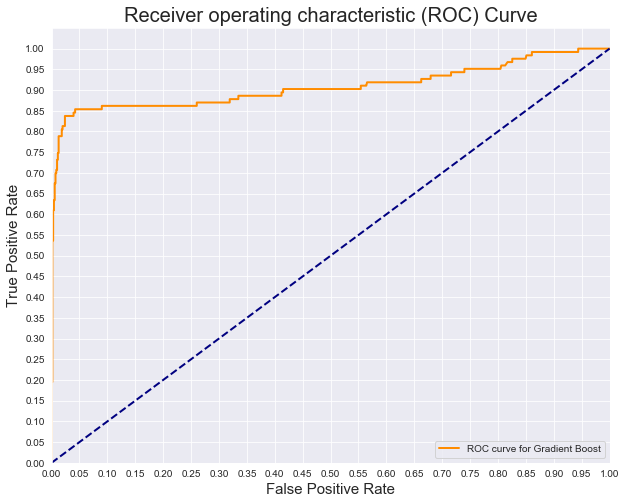

In [108]:
y_score = gbc.fit(X_train, y_train).decision_function(X_test)
# y_score_rf = rft2.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
# fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_score_rf)

print(f'AUC: {auc(fpr, tpr)}')
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve for Gradient Boost')
# plt.plot(fpr_rf, tpr_rf, color='darkgreen',
#          lw=lw, label='ROC curve for Random Forest')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('Receiver operating characteristic (ROC) Curve', fontsize = 20)
plt.legend(loc='lower right')
plt.show()